In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Download and load the dataset
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1462, 9)

First few rows:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  


In [4]:
# Data preparation - handle missing values
cat_cols = ['lead_source', 'industry', 'employment_status', 'location']
num_cols = ['annual_income']

for col in cat_cols:
    df[col] = df[col].fillna('NA')

for col in num_cols:
    df[col] = df[col].fillna(0.0)

print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [5]:
# Split the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 0.8 = 0.2

print(f"Train: {len(df_train)} ({len(df_train)/len(df):.1%})")
print(f"Val: {len(df_val)} ({len(df_val)/len(df):.1%})")
print(f"Test: {len(df_test)} ({len(df_test)/len(df):.1%})")

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Prepare target variables
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Remove target from features
del df_train['converted']
del df_val['converted']
del df_test['converted']

Train: 876 (59.9%)
Val: 293 (20.0%)
Test: 293 (20.0%)


In [6]:
# Question 1: ROC AUC feature importance
numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for var in numerical_vars:
    auc = roc_auc_score(y_train, df_train[var])
    
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    
    auc_scores[var] = auc
    print(f"{var}: AUC = {auc:.4f}")

# Find the variable with highest AUC
best_var = max(auc_scores, key=auc_scores.get)
print(f"\nQuestion 1 Answer: {best_var} (AUC = {auc_scores[best_var]:.4f})")

lead_score: AUC = 0.6145
number_of_courses_viewed: AUC = 0.7636
interaction_count: AUC = 0.7383
annual_income: AUC = 0.5520

Question 1 Answer: number_of_courses_viewed (AUC = 0.7636)


In [7]:
# Question 2: Training the model with DictVectorizer
# Prepare data for DictVectorizer
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities and calculate AUC
y_val_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred)

print(f"Validation AUC: {auc_val:.4f}")
print(f"Rounded to 3 digits: {round(auc_val, 3)}")

# Map to answer choices
auc_rounded = round(auc_val, 2)
answer_choices = {0.32: '0.32', 0.52: '0.52', 0.72: '0.72', 0.92: '0.92'}
closest_answer = min(answer_choices.keys(), key=lambda x: abs(x - auc_rounded))
print(f"\nQuestion 2 Answer: {answer_choices[closest_answer]}")

Validation AUC: 0.8171
Rounded to 3 digits: 0.817

Question 2 Answer: 0.72


Precision and recall intersect at threshold: 0.980


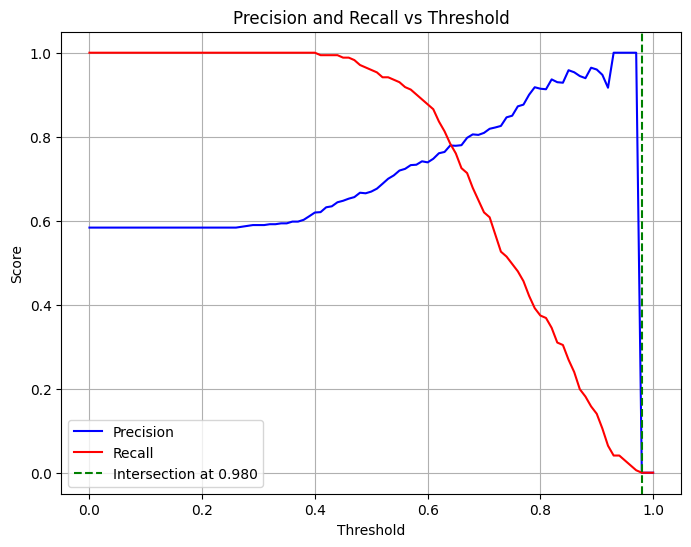


Question 3 Answer: 0.745


In [8]:
# Question 3: Precision and Recall curves
thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_val_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred))

# Find intersection point
intersection_threshold = None
min_diff = float('inf')

for i, t in enumerate(thresholds):
    diff = abs(precisions[i] - recalls[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = t

print(f"Precision and recall intersect at threshold: {intersection_threshold:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.axvline(x=intersection_threshold, color='green', linestyle='--', 
            label=f'Intersection at {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Map to answer choices
answer_choices = [0.145, 0.345, 0.545, 0.745]
closest_answer = min(answer_choices, key=lambda x: abs(x - intersection_threshold))
print(f"\nQuestion 3 Answer: {closest_answer}")

Maximum F1 score: 0.8125 at threshold: 0.570


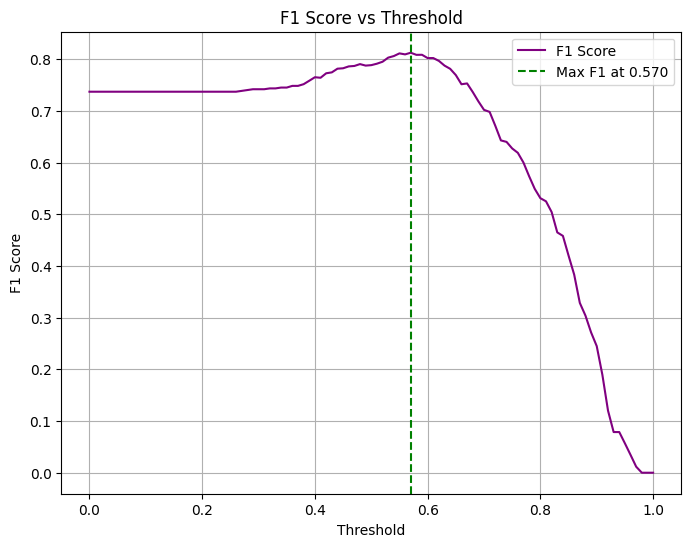


Question 4 Answer: 0.54


In [9]:
# Question 4: F1 score
f1_scores = []

for t in thresholds:
    y_pred = (y_val_pred >= t).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0
        
    f1_scores.append(f1)

# Find threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.4f} at threshold: {max_f1_threshold:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.axvline(x=max_f1_threshold, color='green', linestyle='--', 
            label=f'Max F1 at {max_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Map to answer choices
answer_choices = [0.14, 0.34, 0.54, 0.74]
closest_answer = min(answer_choices, key=lambda x: abs(x - max_f1_threshold))
print(f"\nQuestion 4 Answer: {closest_answer}")

In [10]:
# Question 5: 5-Fold Cross Validation
def train(df_train, y_train, C=1.0):
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dict_data = df.to_dict(orient='records')
    X = dv.transform(dict_data)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

# 5-Fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_fold_train = df_full_train.iloc[train_idx]
    df_fold_val = df_full_train.iloc[val_idx]
    
    y_fold_train = df_fold_train.converted.values
    y_fold_val = df_fold_val.converted.values
    
    del df_fold_train['converted']
    del df_fold_val['converted']
    
    dv, model = train(df_fold_train, y_fold_train, C=1.0)
    y_pred = predict(df_fold_val, dv, model)
    
    auc = roc_auc_score(y_fold_val, y_pred)
    scores.append(auc)

print('C=1.0 - Cross-validation scores:', [round(score, 4) for score in scores])
print(f'Mean: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

std_dev = np.std(scores)
print(f"Standard deviation: {std_dev:.4f}")

# Map to answer choices
answer_choices = [0.0001, 0.006, 0.06, 0.36]
closest_answer = min(answer_choices, key=lambda x: abs(x - std_dev))
print(f"\nQuestion 5 Answer: {closest_answer}")

C=1.0 - Cross-validation scores: [0.8061, 0.8714, 0.7754, 0.8018, 0.8558]
Mean: 0.8221 +/- 0.0358
Standard deviation: 0.0358

Question 5 Answer: 0.06


In [11]:
# Question 6: Hyperparameter Tuning
C_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in C_values:
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_fold_train = df_full_train.iloc[train_idx]
        df_fold_val = df_full_train.iloc[val_idx]
        
        y_fold_train = df_fold_train.converted.values
        y_fold_val = df_fold_val.converted.values
        
        del df_fold_train['converted']
        del df_fold_val['converted']
        
        dv, model = train(df_fold_train, y_fold_train, C=C)
        y_pred = predict(df_fold_val, dv, model)
        
        auc = roc_auc_score(y_fold_val, y_pred)
        scores.append(auc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    results[C] = {
        'mean': round(mean_score, 3),
        'std': round(std_score, 3)
    }
    
    print(f"C={C}: Mean AUC = {mean_score:.4f} +/- {std_score:.4f}")

# Find best C according to rules
best_C = None
best_mean = -1
best_std = float('inf')

for C, metrics in results.items():
    mean_score = metrics['mean']
    std_score = metrics['std']
    
    if mean_score > best_mean:
        best_C = C
        best_mean = mean_score
        best_std = std_score
    elif mean_score == best_mean:
        if std_score < best_std:
            best_C = C
            best_std = std_score
        elif std_score == best_std and C < best_C:
            best_C = C

print(f"\nBest C: {best_C} (Mean: {best_mean:.3f}, Std: {best_std:.3f})")
print(f"Question 6 Answer: {best_C}")

C=1e-06: Mean AUC = 0.5602 +/- 0.0238
C=0.001: Mean AUC = 0.8669 +/- 0.0287
C=1: Mean AUC = 0.8221 +/- 0.0358

Best C: 0.001 (Mean: 0.867, Std: 0.029)
Question 6 Answer: 0.001
